# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 5. Компьютерное зрение & генеративные модели


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 150 баллов
* Задача 2 &mdash; 40 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [ ]:
# Bot check

# HW_ID: fpmi_ad5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [ ]:
!pip install torchinfo

In [ ]:
import time
import warnings
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary

from IPython.display import clear_output
sns.set(font_scale=1, style='darkgrid', palette='Set2')
warnings.simplefilter("ignore")

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_1.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_classification.html" target="_blank">ноутбук</a> про сверточные сети и классификацию, а так же <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_2.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">ноутбук</a> про перенос стиля и генеративные сети.

---
### Задача 1. Классификация MNIST


Цель: сравнить сверточные нейросети с разными параметрами на датасете рукописных цифр MNIST. В нем содержатся черно-белые изображения цифр, всего 10 классов для каждой цифры. Пользоваться кодом семинара можно без ограничений. Классификация MNIST намного легче, чем CIFAR, поэтому ваша задача хотя бы в одной из моделей получить 98% точности **на валидации**.

> Использования слоев с семинара (свертка, pooling) более чем достаточно для достижения 98% точности на тесте. Также не делайте сеть глубокой.

> Тестируйте работоспособность кода на CPU с небольшим кол-вом итераций. Если все работает, и хочется ускорить процесс, переходите на GPU.

Следуйте указаниям ниже.

Загрузим датаcет из `torchvision.datasets`.

In [ ]:
# Данные для обучения
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True,
                                           transform=transforms.ToTensor())
# Данные для тестирования
val_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True,
                                         transform=transforms.ToTensor())
# Классы объектов в датасете
classes = [str(i) for i in range(10)]

100%|██████████| 9912422/9912422 [00:00<00:00, 109257955.38it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 99454592.63it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42368477.97it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20288103.05it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Визуализируйте несколько картинок с соответствующими метками из датасета.

Размер картинки:torch.Size([1, 28, 28])


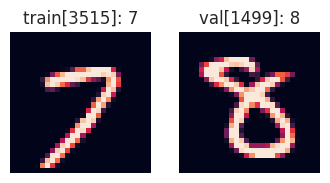

In [ ]:
# берем 2 рандомных индекса
train_idx, val_idx = np.random.randint(0, 10000, 2)
print(f"Размер картинки:{train_dataset[0][0].shape}")

# визуализируем
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(train_dataset[train_idx][0].permute(1, 2, 0))
plt.title(f"train[{train_idx}]: {classes[train_dataset[train_idx][1]]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(val_dataset[val_idx][0].permute(1, 2, 0))
plt.title(f"val[{val_idx}]: {classes[val_dataset[val_idx][1]]}")
plt.axis("off");

Создайте генераторы батчей.

In [ ]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:
def print_epoch(epoch, num_epochs, history, t):
    """
    Функция для вывода информации про эпоху.
    :param epoch: номер эпохи
    :param num_epochs: общее количество эпох
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param t: время эпохи в секундах
    """
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  validation loss: \t{:.6f}".format(history["loss"]["val"][-1]))
    print(
        "  training accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["train"][-1] * 100
        )
    )
    print(
        "  validation accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["val"][-1] * 100
        )
    )


def update_history(history, loss, acc, num_batches, mode):
    """
    Функция для сохранения лосса и точности в историю.
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param loss: сумма лосса за весь батч
    :param acc: сумма точности за весь батч
    :param num_batches: общее количество батчей
    :param mode: train или val
    """
    # Подсчитываем лоссы и сохраняем в "историю"
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)


def get_batch_loss(
    X_batch, y_batch, model, criterion, current_loss, current_acc
):
    """
    Функция для подсчета лосса (без backward pass).
    :param X_batch: батч картиок X
    :param y_batch: батч меток y
    :param model: модель для получения логитов
    :param criterion: функция потерь
    :param current_loss: текущий суммарный лосс за батч
    :param current_acc: текущая суммарная точность за батч
    :return: лосс на данном батче; current_loss; current_acc
    """

    # Обучаемся на батче (одна "итерация" обучения нейросети)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Логиты на выходе модели
    logits = model(X_batch)

    # Подсчитываем лосс
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраняем лоссы и точность на трейне
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc


def train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=40
):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    """

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Считаем лосс, обновляем train_loss, train_acc
            loss, train_loss, train_acc = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc
            )

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(
            history, train_loss, train_acc, len(train_batch_gen), "train"
        )

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)
        # Контекстный менеджер, отключающий подсчет градиентов
        with torch.no_grad():
            # Полный проход по валидационному датасету
            for X_batch, y_batch in val_batch_gen:
                # Считаем лосс, обновляем val_loss, val_acc
                _, val_loss, val_acc = get_batch_loss(
                    X_batch, y_batch, model, criterion, val_loss, val_acc
                )

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, val_loss, val_acc, len(val_batch_gen), "val")

        # Печатаем результаты после каждой эпохи
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

    return history

In [ ]:
def plot_histories(histories, names):
    """
    Функция для визуализации лосса и метрики по нескольким историям.
    :param history: (list) список историй моделей
    :param names: (list) список названий моделей
    """
    sns.set_style("darkgrid")
    colors = ["darkblue", "lightcoral", "limegreen", "sandybrown", "red"]
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    epochs = np.min([len(h["loss"]["train"]) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title("Лосс")
        axs[0].plot(
            history["loss"]["train"][:epochs],
            label=f"{name}",
            lw=2,
            c=colors[i],
        )
        axs[0].plot(
            history["loss"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[0].set_xlabel("Эпохи")

        axs[1].set_title("Точность")
        axs[1].plot(
            history["acc"]["train"][:epochs], label=f"{name}", lw=2, c=colors[i]
        )
        axs[1].plot(
            history["acc"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[1].set_xlabel("Эпохи")
        axs[1].legend()

    dummy_lines = [
        axs[0].plot([], [], c="black", lw=2)[0],
        axs[0].plot([], [], c="black", lw=1.5, ls="--")[0],
    ]
    for i in range(2):
        legend = axs[i].legend(loc=3 - i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

**Эксперимент 1.** Создайте хотя бы 5 сверточных нейросетей с разным количеством линейных и сверточных слоев. Должен присутствовать хотя бы 1 сверточный слой и хотя бы 1 линейный слой. Для каждой посмотрите количество параметров с помощью `torchinfo.summary`.

In [ ]:
simple_cnn1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

In [ ]:
summary(simple_cnn1, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 256]                  409,856
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 431,242
Trainable params: 431,242
Non-trainable params: 0
Total mult-adds (M): 2.87
Input size (MB): 0.00
Forward/backward pass 

In [ ]:
simple_cnn2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=5408, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

In [ ]:
summary(simple_cnn2, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Flatten: 1-4                           [1, 5408]                 --
├─Linear: 1-5                            [1, 256]                  1,384,704
├─ReLU: 1-6                              [1, 256]                  --
├─Linear: 1-7                            [1, 10]                   2,570
Total params: 1,387,594
Trainable params: 1,387,594
Non-trainable params: 0
Total mult-adds (M): 1.60
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 5.55
Estimated Total Size (MB): 5.73

In [ ]:
simple_cnn3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=5408, out_features=10)
).to(device)

In [ ]:
summary(simple_cnn3, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Flatten: 1-4                           [1, 5408]                 --
├─Linear: 1-5                            [1, 10]                   54,090
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
Total mult-adds (M): 0.27
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.22
Estimated Total Size (MB): 0.39

In [ ]:
simple_cnn4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=10)
).to(device)

In [ ]:
summary(simple_cnn4, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 10]                   16,010
Total params: 34,826
Trainable params: 34,826
Non-trainable params: 0
Total mult-adds (M): 2.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.14
Estimated Total Size (MB): 0.38

In [ ]:
simple_cnn5 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=128, out_features=10)
).to(device)

In [ ]:
summary(simple_cnn5, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Conv2d: 1-7                            [1, 128, 3, 3]            73,856
├─MaxPool2d: 1-8                         [1, 128, 1, 1]            --
├─ReLU: 1-9                              [1, 128, 1, 1]            --
├─Flatten: 1-10                          [1, 128]                  --
├─Linear: 1-11                           [1, 10]                   1,290
Total params: 93,962
Trainable params: 93,962
Non-trainable params: 0
Tot

Обучите сети, используя функцию потерь `nn.CrossEntropyLoss` и оптимизатор `torch.optim.Adam` с дефолтными параметрами.

In [ ]:
criterion = nn.CrossEntropyLoss()

history_cnn = []
cnn_times = []
for simple_cnn in [simple_cnn1, simple_cnn2, simple_cnn3, simple_cnn4, simple_cnn5]:
  optimizer = torch.optim.Adam(simple_cnn.parameters())
  begin_time = time.time()
  current_history_cnn = train(
      simple_cnn,
      criterion,
      optimizer,
      train_batch_gen,
      val_batch_gen,
      num_epochs=5,
  )
  cur_cnn_time = time.time() - begin_time
  cnn_times.append(cur_cnn_time)
  history_cnn.append(current_history_cnn)

# Сохраняем веса модели в файл
torch.save(simple_cnn1.state_dict(), "simple_cnn1.pth")
torch.save(simple_cnn2.state_dict(), "simple_cnn2.pth")
torch.save(simple_cnn3.state_dict(), "simple_cnn3.pth")
torch.save(simple_cnn4.state_dict(), "simple_cnn4.pth")
torch.save(simple_cnn5.state_dict(), "simple_cnn5.pth")

Epoch 5 of 5 took 9.755 s
  training loss: 	0.034914
  validation loss: 	0.051668
  training accuracy: 			98.94 %
  validation accuracy: 			98.45 %


Постройте график лосса и график accuracy, где сравниваются все модели (на train и на val). Нужная функция есть в семинаре.

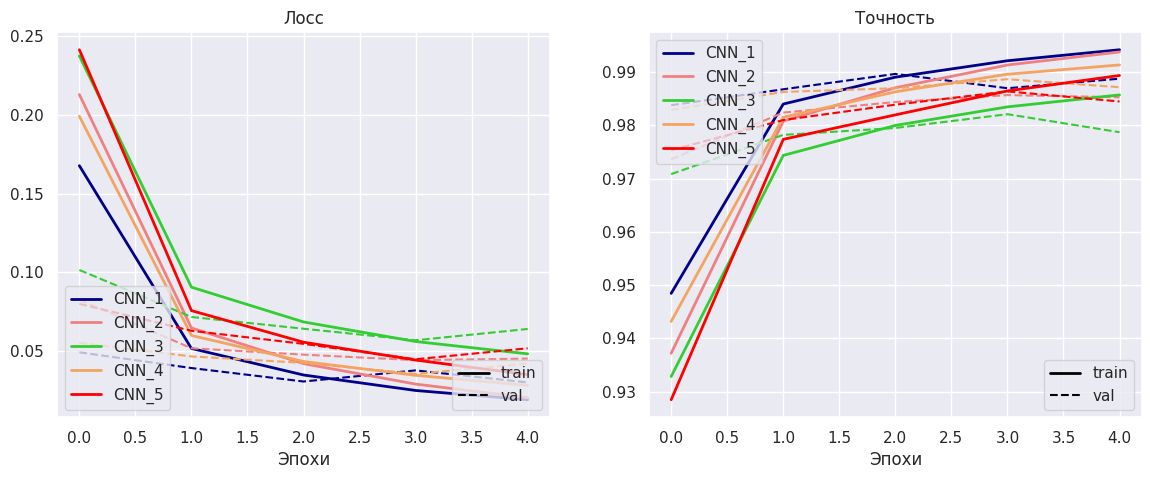

In [ ]:
plot_histories(history_cnn, ["CNN_1", "CNN_2", "CNN_3", "CNN_4", "CNN_5"])

In [ ]:
for i in range(5):
  print("for", i, "cnn:", cnn_times[i])

for 0 cnn: 59.93341302871704
for 1 cnn: 45.76204967498779
for 2 cnn: 46.466487646102905
for 3 cnn: 48.03520202636719
for 4 cnn: 48.72526669502258


Сделайте вывод. Как количество разных слоев влияет на качество и время обучения?

**Вывод по эксперименту 1:**

На наших данных время обучения примерно одинаковое (в пределах погрешности), и все модели выдают примерно одинаковые точные результаты.
На валидационной и тренировочной выборки точность модели cnn3 чуть ниже, чем у других. Там было меньше всего слоев - один сверточный и один линейный. Можно сделать предположение, что при прочих равных это привело к меньшей точности.

**Эксперимент 2.** Теперь выберите лучший вариант, зафиксируйте это количество сверточных и линейных слоев и обучите хотя бы 4 сверточных нейросети, варьируя размеры ядер сверток. Например, в разном порядке поставьте ядра 3x3, 5x5.

In [ ]:
simple_cnn_33 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

In [ ]:
summary(simple_cnn_33, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 256]                  409,856
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 431,242
Trainable params: 431,242
Non-trainable params: 0
Total mult-adds (M): 2.87
Input size (MB): 0.00
Forward/backward pass 

In [ ]:
simple_cnn_55 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

In [ ]:
summary(simple_cnn_55, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 24, 24]           832
├─MaxPool2d: 1-2                         [1, 32, 12, 12]           --
├─ReLU: 1-3                              [1, 32, 12, 12]           --
├─Conv2d: 1-4                            [1, 64, 8, 8]             51,264
├─MaxPool2d: 1-5                         [1, 64, 4, 4]             --
├─ReLU: 1-6                              [1, 64, 4, 4]             --
├─Flatten: 1-7                           [1, 1024]                 --
├─Linear: 1-8                            [1, 256]                  262,400
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 317,066
Trainable params: 317,066
Non-trainable params: 0
Total mult-adds (M): 4.03
Input size (MB): 0.00
Forward/backward pass 

In [ ]:
simple_cnn_35 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

In [ ]:
summary(simple_cnn_35, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 9, 9]             51,264
├─MaxPool2d: 1-5                         [1, 64, 4, 4]             --
├─ReLU: 1-6                              [1, 64, 4, 4]             --
├─Flatten: 1-7                           [1, 1024]                 --
├─Linear: 1-8                            [1, 256]                  262,400
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 316,554
Trainable params: 316,554
Non-trainable params: 0
Total mult-adds (M): 4.63
Input size (MB): 0.00
Forward/backward pass 

In [ ]:
simple_cnn_53 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

In [ ]:
summary(simple_cnn_53, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 24, 24]           832
├─MaxPool2d: 1-2                         [1, 32, 12, 12]           --
├─ReLU: 1-3                              [1, 32, 12, 12]           --
├─Conv2d: 1-4                            [1, 64, 10, 10]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 256]                  409,856
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 431,754
Trainable params: 431,754
Non-trainable params: 0
Total mult-adds (M): 2.74
Input size (MB): 0.00
Forward/backward pass 

In [ ]:
criterion = nn.CrossEntropyLoss()

history_cnn_kernel = []
cnn_times_kernel = []
for simple_cnn in [simple_cnn_33, simple_cnn_55, simple_cnn_35, simple_cnn_53]:
  optimizer = torch.optim.Adam(simple_cnn.parameters())
  begin_time = time.time()
  current_history_cnn = train(
      simple_cnn,
      criterion,
      optimizer,
      train_batch_gen,
      val_batch_gen,
      num_epochs=5,
  )
  cur_cnn_time = time.time() - begin_time
  cnn_times_kernel.append(cur_cnn_time)
  history_cnn_kernel.append(current_history_cnn)

# Сохраняем веса модели в файл
torch.save(simple_cnn_33.state_dict(), "simple_cnn_33.pth")
torch.save(simple_cnn_55.state_dict(), "simple_cnn_55.pth")
torch.save(simple_cnn_35.state_dict(), "simple_cnn_35.pth")
torch.save(simple_cnn_53.state_dict(), "simple_cnn_53.pth")

Epoch 5 of 5 took 9.794 s
  training loss: 	0.018778
  validation loss: 	0.023189
  training accuracy: 			99.41 %
  validation accuracy: 			99.26 %


Постройте график лосса и график accuracy, где сравниваются все модели этого эксперимента (на train и на val).

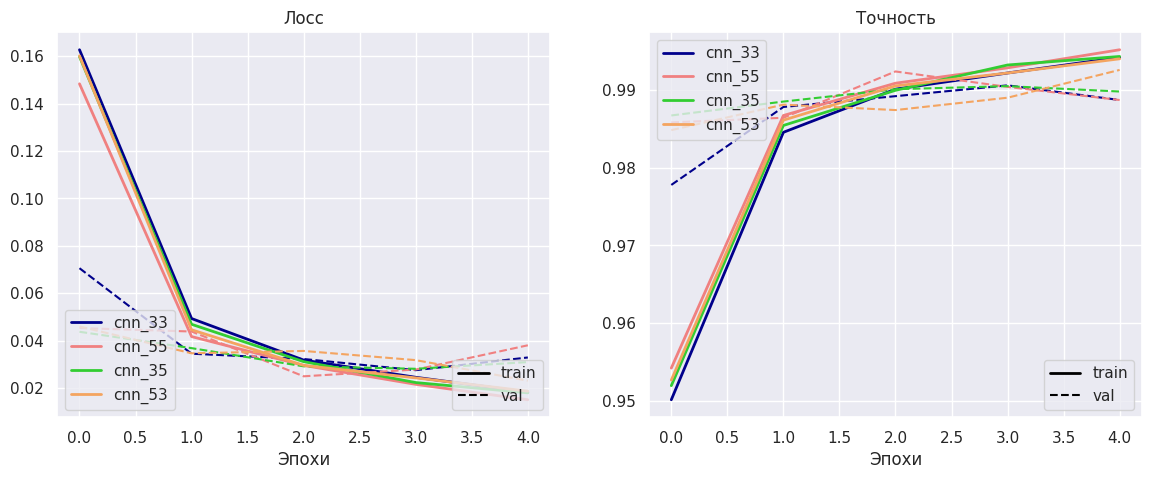

In [ ]:
plot_histories(history_cnn_kernel, ["cnn_33", "cnn_55", "cnn_35", "cnn_53"])

In [ ]:
for i in range(4):
  print("for", i, "cnn:", cnn_times_kernel[i])

for 0 cnn: 48.52214860916138
for 1 cnn: 49.576295614242554
for 2 cnn: 49.73627543449402
for 3 cnn: 48.062681436538696


Сделайте вывод. Как размеры ядер влияют на качество и время обучения?

**Вывод по эксперименту 2:**

Точность и время обучения не сильно различаются (в пределах погрешности).
На нашей выборке и в данной модели cnn53 оказалась чуть точнее других.

**Анализ лучшей модели.** Выберите лучшую конфигурацию из всех по accuracy на валидации. Она должна быть не меньше 98%.

In [ ]:
for i in range(4):
  print(i, history_cnn_kernel[i]['acc']['val'][-1])

0 0.9887539808917197
1 0.9887539808917197
2 0.9898487261146497
3 0.9926353503184714


Проведите еще один проход валидации выбранной моделью по всему датасету. В нем посчитайте точность по каждому классу и соберите информацию о неправильных предсказаниях. Равномерна ли точность по отношению к классам? Покажите 10-20 примеров, на которых нейросеть выдала неправильную метку. Что можно о них сказать?

In [ ]:
counter = np.zeros(10)
mistakes_counter = np.zeros(10)
mistakes_indices_val = []
mistakes_indices_train = []

for i in range(10000):
  image, label = val_dataset[i]
  counter[label] += 1
  logits_cnn = simple_cnn_53(image.to(device).unsqueeze(0))[0].cpu()
  prob_cnn = torch.softmax(logits_cnn, dim=0).detach().numpy()
  if np.argmax(prob_cnn) != label:
    mistakes_counter[label] += 1
    mistakes_indices_val.append(i)

for i in range(60000):
  image, label = train_dataset[i]
  counter[label] += 1
  logits_cnn = simple_cnn(image.to(device).unsqueeze(0))[0].cpu()
  prob_cnn = torch.softmax(logits_cnn, dim=0).detach().numpy()
  if np.argmax(prob_cnn) != label:
    mistakes_counter[label] += 1
    mistakes_indices_train.append(i)

print(counter)
print(mistakes_counter)

[6903. 7877. 6990. 7141. 6824. 6313. 6876. 7293. 6825. 6958.]
[ 9.  8. 23. 38. 25. 45. 25. 25. 15. 43.]


In [10]:
for i in range(10):
  print(i, mistakes_counter[i]/counter[i] * 100, "%")

0 0.1303780964797914 %
1 0.10156150818839661 %
2 0.3290414878397711 %
3 0.5321383559725529 %
4 0.36635404454865184 %
5 0.7128148265483922 %
6 0.3635834787667248 %
7 0.3427944604415193 %
8 0.21978021978021978 %
9 0.6179936763437769 %


In [ ]:
len(mistakes_indices_val)

74

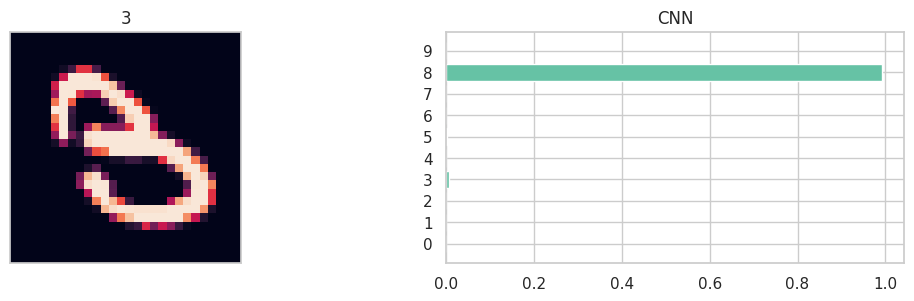

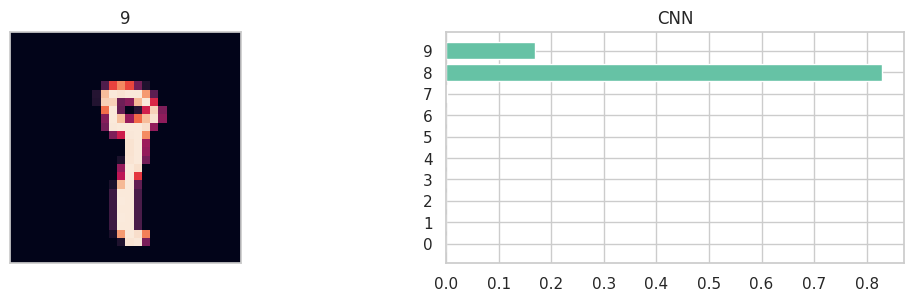

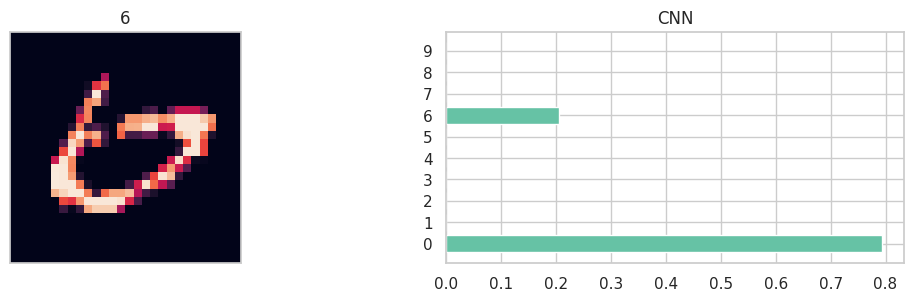

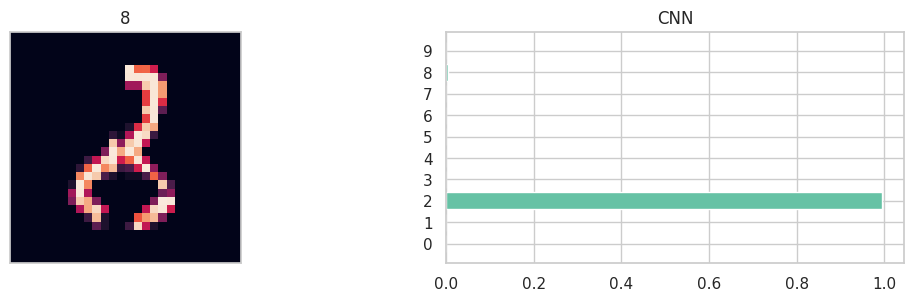

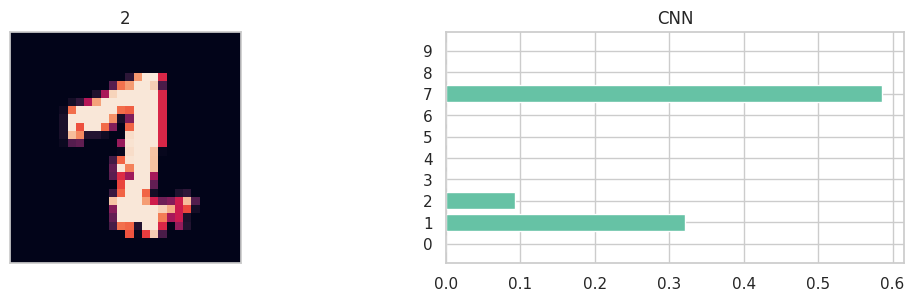

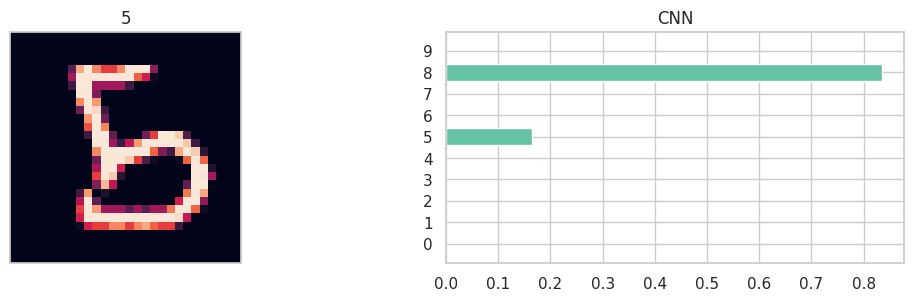

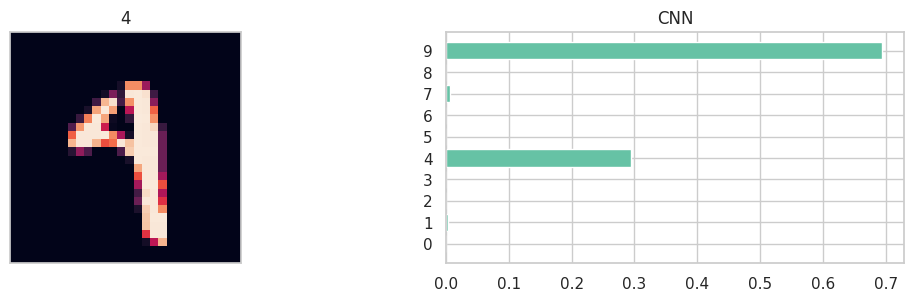

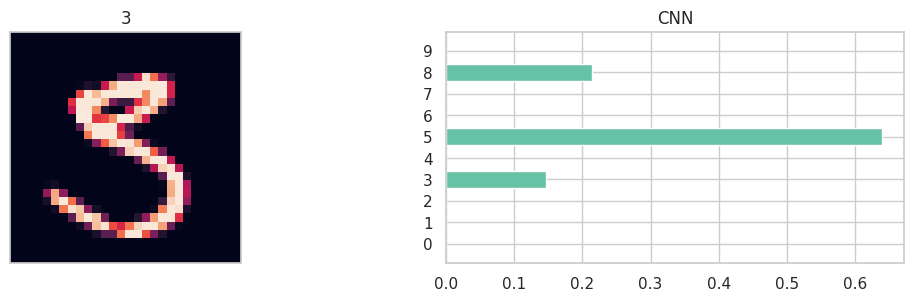

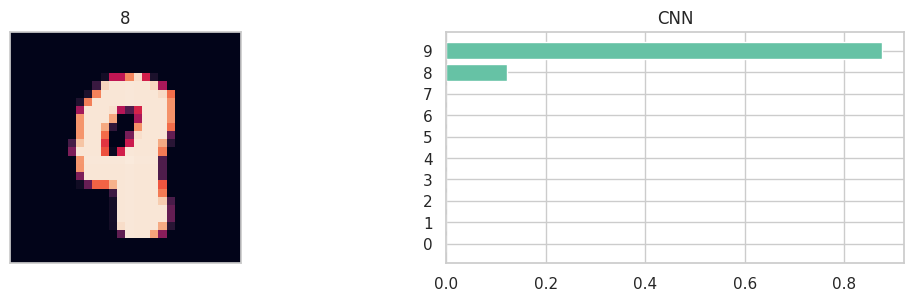

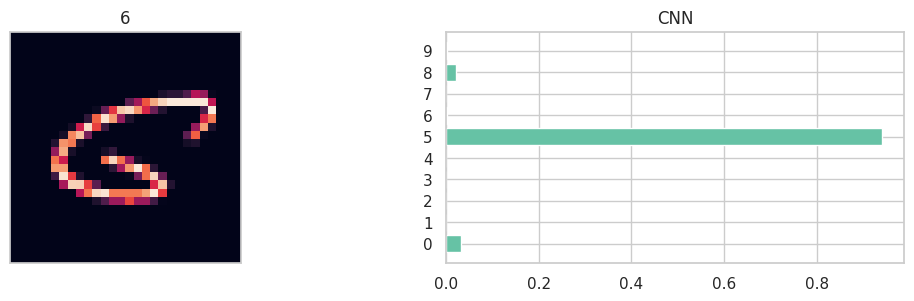

In [ ]:
for i in range(10):
  with sns.axes_style("whitegrid"):
    plt.figure(figsize=(13, 3))
    image, label = val_dataset[mistakes_indices_val[i]]
    logits_cnn = simple_cnn(image.to(device).unsqueeze(0))[0].cpu()
    prob_cnn = torch.softmax(logits_cnn, dim=0).detach().numpy()

    plt.subplot(1, 2, 1)
    plt.imshow(image.permute((1, 2, 0)))
    plt.title(classes[label])
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 2, 2)
    plt.barh(classes, prob_cnn)
    plt.title("CNN")

    plt.show()

**Ответ:**

Ошибки неравномерно распределены по цифрам.
Больше всего ошибок (в процентном соотношении) на цифрах 5, 9 и 3.
Меньше всего ошибок на цифрах 0 и 1.
Это может быть связано с тем, что некоторые цифры проще спутать с другими.

Выведенные рисунки цифр, на которых предсказание нейросети оказалось неверно, не совсем аккуратны. Не на всех рисунках понятно, что в целом написано.

**Вывод по всей задаче:**
Были изучены сверточные нейросети с разным количеством слоев и ядер.
Они дают досточно точные результаты для распознавания цифр.

---
### Задача 2. Перенос стиля

Здесь вы потренируетесь в работе с картинками и составлением промптов. Используя код с <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">семинара</a>, проведите перенос стиля на хотя бы 3 своих примерах.

> Заметьте, что в примерах с семинара в качестве картинок стиля и контента использовались картинки среднего разрешения. Если возникают проблемы: оптимизация останавливается на 0-й эпохе и не создает картинку; loss в какой-то момент стал nan; нехватка RAM; &mdash; то либо уменьшите разрешение ваших картинок, либо попробуйте картинку полегче.

In [ ]:
import os
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

sns.set(palette="Set2")

In [ ]:
!git clone https://github.com/nazianafis/Neural-Style-Transfer
# Перейдем в директорию скачанного репозитория
%cd /content/Neural-Style-Transfer/

# Небольшая обработка скрипта, не менять!
file_path = "NST.py"
with open(file_path, "r") as file:
    # Убираем автоматический запуск
    lines = file.readlines()[:183]
# Вывод логов только каждые 100 эпох
lines = lines[:175] + ["            if cnt % 100 == 0:\n"] + lines[175:]
lines[176] = "    " + lines[176]
with open(file_path, "w") as file:
    file.writelines(lines)

from NST import *

Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 379 (delta 72), reused 105 (delta 34), pack-reused 225
Receiving objects: 100% (379/379), 92.21 MiB | 34.19 MiB/s, done.
Resolving deltas: 100% (143/143), done.
/content/Neural-Style-Transfer


In [ ]:
def run_neural_style_transfer(content_image="c1.jpg", style_image="s1.jpg"):
    """
    Функция для запуска метода Neural Style Transfer.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :return: results_path -- путь к папке, в которую сохранился результат
    """
    PATH = ""
    default_resource_dir = os.path.join(PATH, "data")
    content_images_dir = os.path.join(default_resource_dir, "content-images")
    style_images_dir = os.path.join(default_resource_dir, "style-images")
    output_img_dir = os.path.join(default_resource_dir, "output-images")
    img_format = (4, ".jpg")

    # Задаем конфиги, включая вес компонент лосса
    optimization_config = {
        "content_img_name": content_image,
        "style_img_name": style_image,
        "height": 400,
        "content_weight": 100000.0,
        "style_weight": 30000.0,
        "tv_weight": 1.0,
    }
    optimization_config["content_images_dir"] = content_images_dir
    optimization_config["style_images_dir"] = style_images_dir
    optimization_config["output_img_dir"] = output_img_dir
    optimization_config["img_format"] = img_format

    results_path = neural_style_transfer(optimization_config)
    return results_path

In [ ]:
def visualize_style_transfer(content_image, style_image, results_path):
    """
    Визуализация результатов.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :param results_path: путь к папке, в которую сохранился результат
    """
    if len(os.listdir(results_path)) == 0:
        return
    plt.figure(figsize=(13, 3))
    folders = [
        "content-images/",
        "output-images/" + Path(results_path).name + "/",
        "style-images/",
    ]
    combined_image = (
        Path(content_image).stem + "_" + Path(style_image).stem + ".jpg"
    )
    files = [content_image, combined_image, style_image]
    titles = ["Контент", "Результат", "Стиль"]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(plt.imread("data/" + folders[i] + files[i]))
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])

In [ ]:
# подключим Google Drive
from google.colab import drive

drive.mount("/content/drive")

# пути к нужным папкам в Drive
content_path = "/content/drive/MyDrive/DS/style_transfer_images/content"
style_path = "/content/drive/MyDrive/DS/style_transfer_images/style"

# очистим предыдущие картинки, скопируем новые
!rm -r data/content-images
!mkdir data/content-images
!cp -a /$content_path/. data/content-images/

!rm -r data/style-images
!mkdir data/style-images
!cp -a /$style_path/. data/style-images/

Mounted at /content/drive


In [ ]:
content_images = sorted(os.listdir("data/content-images"))
style_images = sorted(os.listdir("data/style-images"))
result_paths = []
for content_image, style_image in zip(content_images, style_images):
    results_path = run_neural_style_transfer(content_image, style_image)
    result_paths.append(results_path)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 116MB/s]


Using VGG19 in the optimization procedure.
L-BFGS | iteration: 000, total loss=2197983985664.0000, content_loss=      0.0000, style loss=2197979280000.0000, tv loss=4662089.0000
L-BFGS | iteration: 100, total loss=23645171712.0000, content_loss=3198619140.6250, style loss=20439457500.0000, tv loss=7095208.0000
L-BFGS | iteration: 200, total loss=12127666176.0000, content_loss=3316598828.1250, style loss=8803333125.0000, tv loss=7734474.0000
L-BFGS | iteration: 300, total loss=9840565248.0000, content_loss=3352602734.3750, style loss=6479862656.2500, tv loss=8100234.0000
L-BFGS | iteration: 400, total loss=8798660608.0000, content_loss=3379769921.8750, style loss=5410366406.2500, tv loss=8524164.0000
L-BFGS | iteration: 500, total loss=8208294400.0000, content_loss=3396759375.0000, style loss=4802613281.2500, tv loss=8921664.0000
L-BFGS | iteration: 600, total loss=7801939456.0000, content_loss=3405677734.3750, style loss=4386970781.2500, tv loss=9291276.0000
L-BFGS | iteration: 700, to

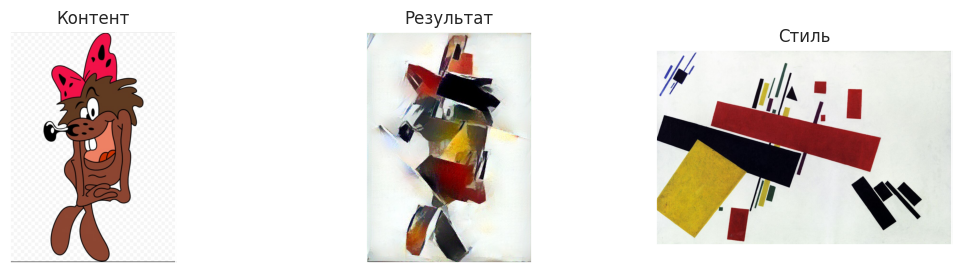

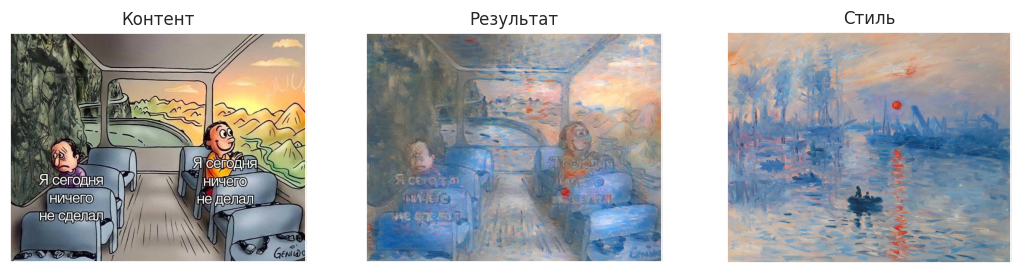

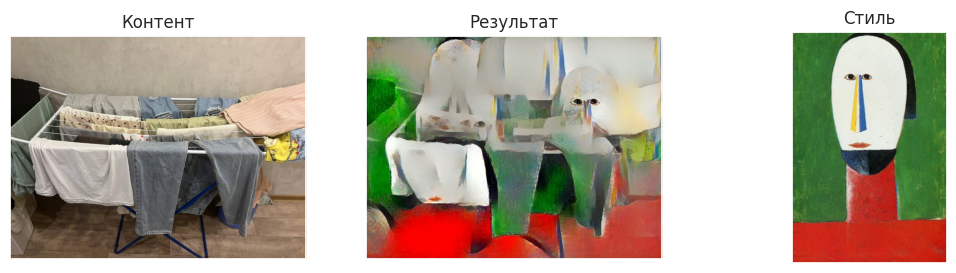

In [ ]:
# Сохраним результаты
!cp -r data/output-images /content/drive/MyDrive/DS

# Визуализируем
for content_image, style_image, results_path in zip(
    content_images, style_images, result_paths
):
    visualize_style_transfer(content_image, style_image, results_path)

Теперь для каждой пары контекст-стиль попытайтесь сгенерировать картинку с таким контекстом и стилем с помощью диффузионной модели, рассмотренной на семинаре, задав нужный промпт.

In [1]:
!pip install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.5 MB/s eta 0:00:00


In [2]:
from diffusers import AutoPipelineForText2Image
import torch

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

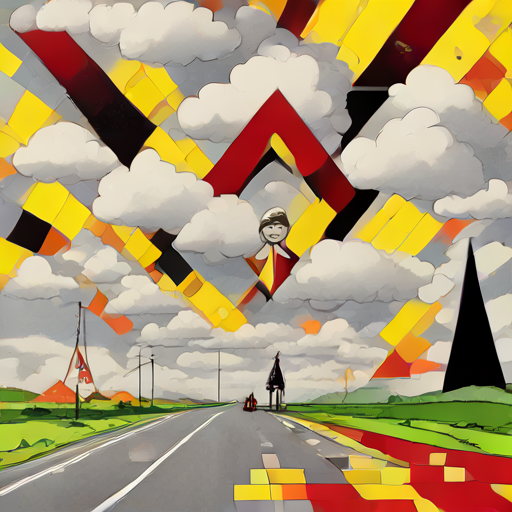

In [6]:
prompt = "negative character (Dyudyuka barbidokskaya) from the Soviet cartoon On the Road with the Clouds from red, yellow, black and white rectangles and triangles"

# Передаем prompt в pipe, указываем параметры
# Модель проводит генерацию картинки, соответствующей запросу
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

  0%|          | 0/1 [00:00<?, ?it/s]

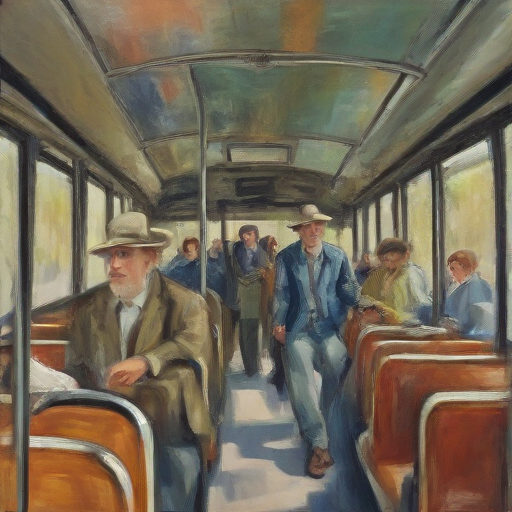

In [4]:
prompt = "meme where a man rides on a bus as if it were an impressionist painting"
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

  0%|          | 0/1 [00:00<?, ?it/s]

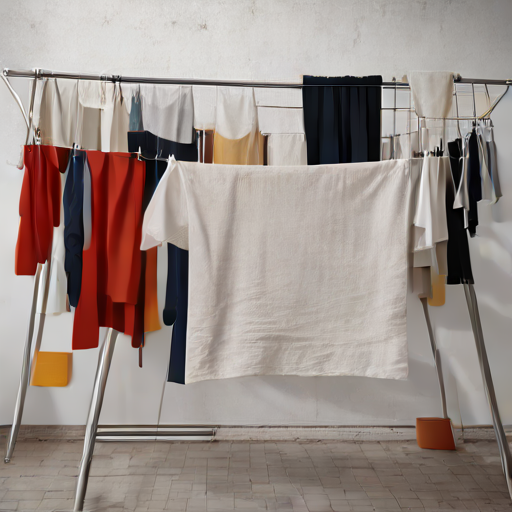

In [5]:
prompt = "a photo of clothes on a drying rack in Malevich style"
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

**Вывод:**

Удалось получить картинки в результате работы генеративной нейросети, похожие на результат переноса стиля. Кроме Дюдюки Барбидокской, потому что она вредина. Ух, Дюдюка!